<a href="https://colab.research.google.com/github/PioDru/colab/blob/main/breast_cancer_image_calssification_effecientb3_pdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3, EfficientNetV2S, EfficientNetV2M
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
#!/bin/bash
!curl -L -o ./breast-usg.zip https://www.kaggle.com/api/v1/datasets/download/aryashah2k/breast-ultrasound-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  194M  100  194M    0     0   105M      0  0:00:01  0:00:01 --:--:--  160M


In [3]:
!unzip -q ./breast-usg.zip  -d breast-usg

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob

# Generate data paths with labels
#data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
data_dir = '/content/breast-usg/Dataset_BUSI_with_GT'
# Ścieżka do pliku CSV zawierającego listę nazw plików (bez ścieżek)
csv_path = "/content/usgValidFilenames.csv"
# Wczytaj CSV i utwórz zbiór (set) do szybkiego sprawdzania
df_csv = pd.read_csv(csv_path)
# Zakładamy, że kolumna zawiera nazwy plików (np. "benign (124).png")
allowed_files = set(df_csv['filename'].str.lower())

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    # Pomijamy pliki mask (zawierające "mask" w nazwie)
    filelist = [f for f in filelist if "mask" not in os.path.basename(f).lower()]
    # Filtrujemy tylko te pliki, których nazwy (basename) znajdują się w allowed_files
    filelist = [f for f in filelist if os.path.basename(f).lower() in allowed_files]
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
1,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
2,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
3,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
4,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
...,...,...
328,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
329,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
330,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
331,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal


In [6]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#balansowanie danych + oversampling

dataset_path = "/content/breast-usg/Dataset_BUSI_with_GT"

classes = ['benign', 'malignant', 'normal']
dataframes = []

for cls in classes:
    # Pobieramy wszystkie pliki PNG z folderu danej klasy
    files = glob.glob(os.path.join(dataset_path, cls, "*.png"))
    # Pomijamy pliki zawierające "mask" w nazwie, jeśli chcemy pracować z oryginalnymi obrazami
    files = [f for f in files if "mask" not in os.path.basename(f).lower()]
    # Filtrujemy tylko te pliki, których nazwy (basename) znajdują się w allowed_files
    files = [f for f in files if os.path.basename(f).lower() in allowed_files]
    df_cls = pd.DataFrame({'filepaths': files, 'labels': cls})
    dataframes.append(df_cls)

# Łączymy dane ze wszystkich klas
df_all = pd.concat(dataframes, ignore_index=True)
print("Rozkład klas przed balansowaniem:")
print(df_all['labels'].value_counts())

# Oversampling: dla każdej klasy powielamy próbki (losowo z powtórzeniami) tak, aby liczba próbek dla każdej klasy była równa max_count
max_count = df_all['labels'].value_counts().max()

df_balanced = df_all.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(n=max_count, replace=True, random_state=42)
).reset_index(drop=True)

Rozkład klas przed balansowaniem:
labels
benign       168
malignant    117
normal        48
Name: count, dtype: int64


In [7]:
strat = df['labels']
#train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
#train_df, temp_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)
train_df, temp_df = train_test_split(df_balanced,  train_size= 0.7, shuffle= True, random_state= 123, stratify= df_balanced['labels'])
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['labels']
)


In [8]:
test_df

,filepaths,labels
280,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
69,/content/breast-usg/Dataset_BUSI_with_GT/benig...,benign
331,/content/breast-usg/Dataset_BUSI_with_GT/malig...,malignant
105,/content/breast-usg/Dataset_BUSI_with_GT/benig...,benign
98,/content/breast-usg/Dataset_BUSI_with_GT/benig...,benign
...,...,...
475,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
344,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
460,/content/breast-usg/Dataset_BUSI_with_GT/norma...,normal
84,/content/breast-usg/Dataset_BUSI_with_GT/benig...,benign



Liczba próbek w podziale:
Treningowy: 352
Walidacyjny: 76
Testowy: 76


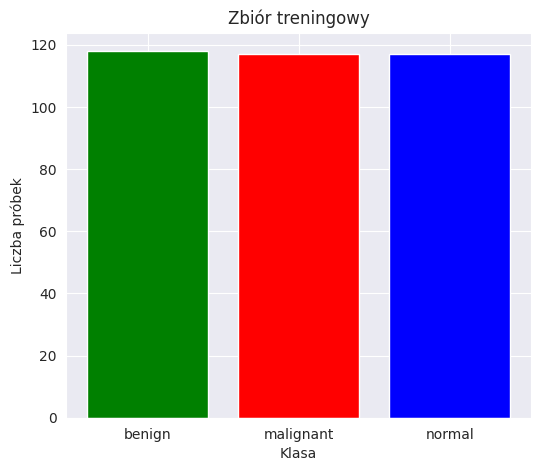

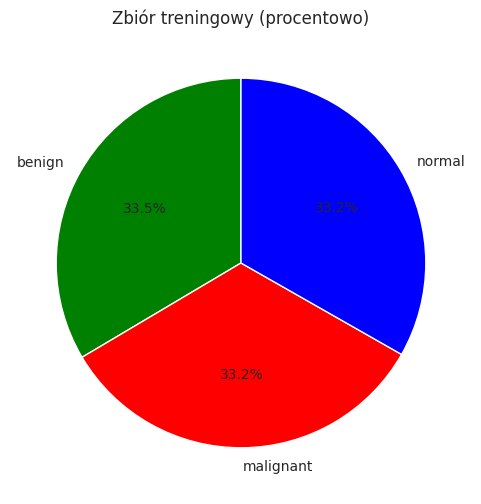

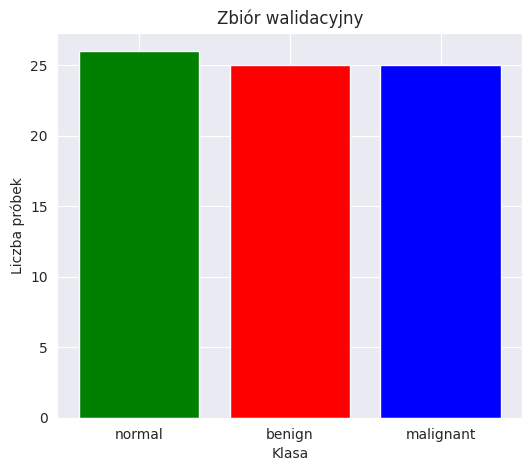

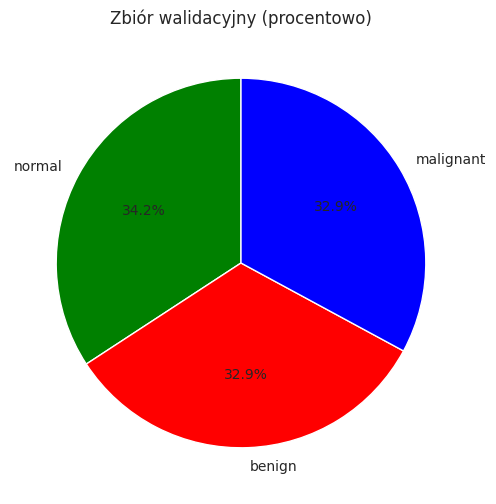

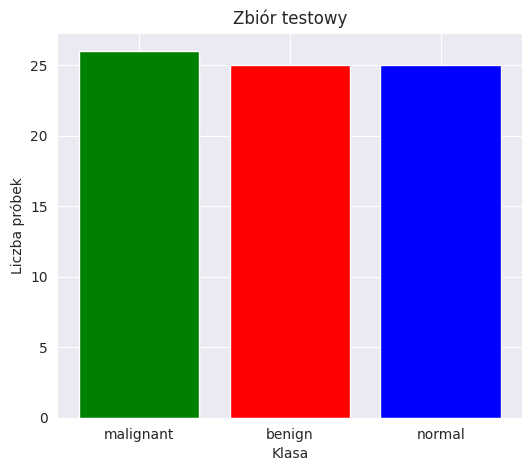

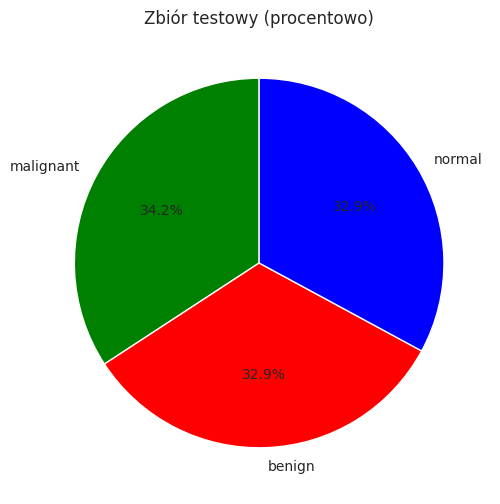

In [9]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("\nLiczba próbek w podziale:")
print("Treningowy:", train_df.shape[0])
print("Walidacyjny:", val_df.shape[0])
print("Testowy:", test_df.shape[0])

# Wizualizacja rozkładu klas w poszczególnych zbiorach
def plot_class_distribution(df, title):
    counts = df['labels'].value_counts()
    plt.figure(figsize=(6,5))
    plt.bar(counts.index, counts.values, color=['green', 'red', 'blue'])
    plt.xlabel('Klasa')
    plt.ylabel('Liczba próbek')
    plt.title(title)
    plt.show()

    plt.figure(figsize=(6,6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90,
            colors=['green', 'red', 'blue'])
    plt.title(title + " (procentowo)")
    plt.show()

plot_class_distribution(train_df, "Zbiór treningowy")
plot_class_distribution(val_df, "Zbiór walidacyjny")
plot_class_distribution(test_df, "Zbiór testowy")

In [10]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
vl_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

val_gen = vl_gen.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 352 validated image filenames belonging to 3 classes.
Found 76 validated image filenames belonging to 3 classes.
Found 76 validated image filenames belonging to 3 classes.


In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model = EfficientNetV2S(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

#base_model.trainable = False

model = Sequential([
    base_model,
    #BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    #Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #Dropout(rate= 0.45, seed= 123),
    BatchNormalization(),
    Dense(1536, activation='relu'),
    Dropout(rate= 0.45),
    Dense(256, activation='relu'),
    Dropout(rate= 0.3),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1536)                │       2,360,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,544,754 (51.67 MB)

 Trainable params: 13,454,379 (51.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [12]:
epochs = 50   # number of all epochs in training

#history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, validation_steps= None, shuffle= False)
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, validation_steps= None, shuffle= False)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 152s 671ms/step - accuracy: 0.4518 - loss: 1.4663 - val_accuracy: 0.5921 - val_loss: 1.1561
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8249 - loss: 0.4469 - val_accuracy: 0.7763 - val_loss: 0.4742
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9021 - loss: 0.2610 - val_accuracy: 0.7895 - val_loss: 0.7025
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9392 - loss: 0.2014 - val_accuracy: 0.8816 - val_loss: 0.5074
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9539 - loss: 0.1226 - val_accuracy: 0.8684 - val_loss: 0.4630
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9615 - loss: 0.1102 - val_accuracy: 0.8684 - val_loss: 0.5515
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9800 - loss: 0.0816 - val_accuracy: 0.7895 - val_loss: 0.9129
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9259 - loss: 0.2553 - val_accuracy: 

In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 5.5596e-05
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8812 - loss: 0.3536
Train Loss:  9.654424502514303e-05
Train Accuracy:  1.0
--------------------
Test Loss:  0.2315150797367096
Test Accuracy:  0.9210526347160339


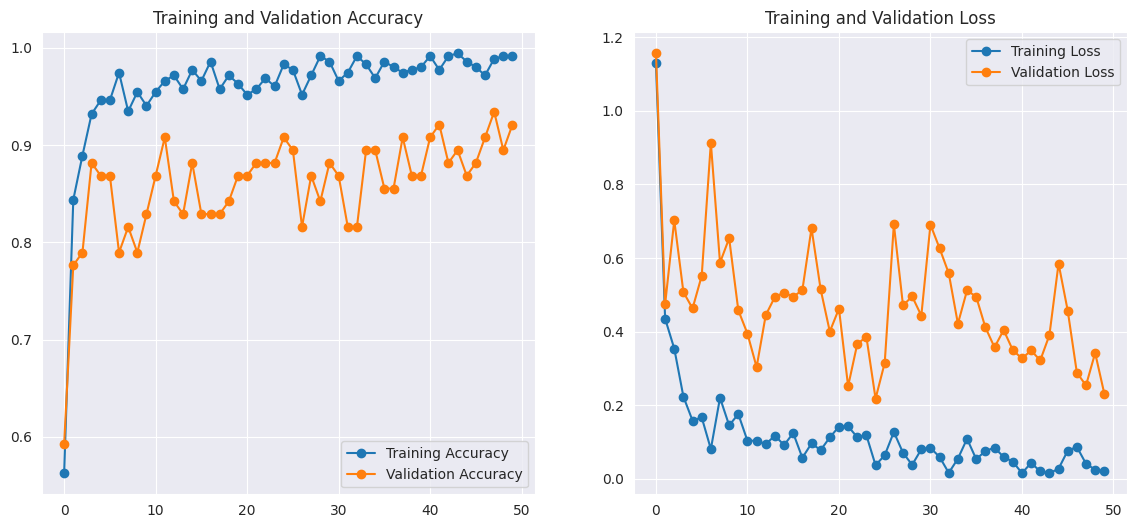

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import itertools

# Zakładamy, że obiekt `history` został zwrócony przez model.fit
# history = model.fit(...)

# Wykres accuracy i loss dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [15]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


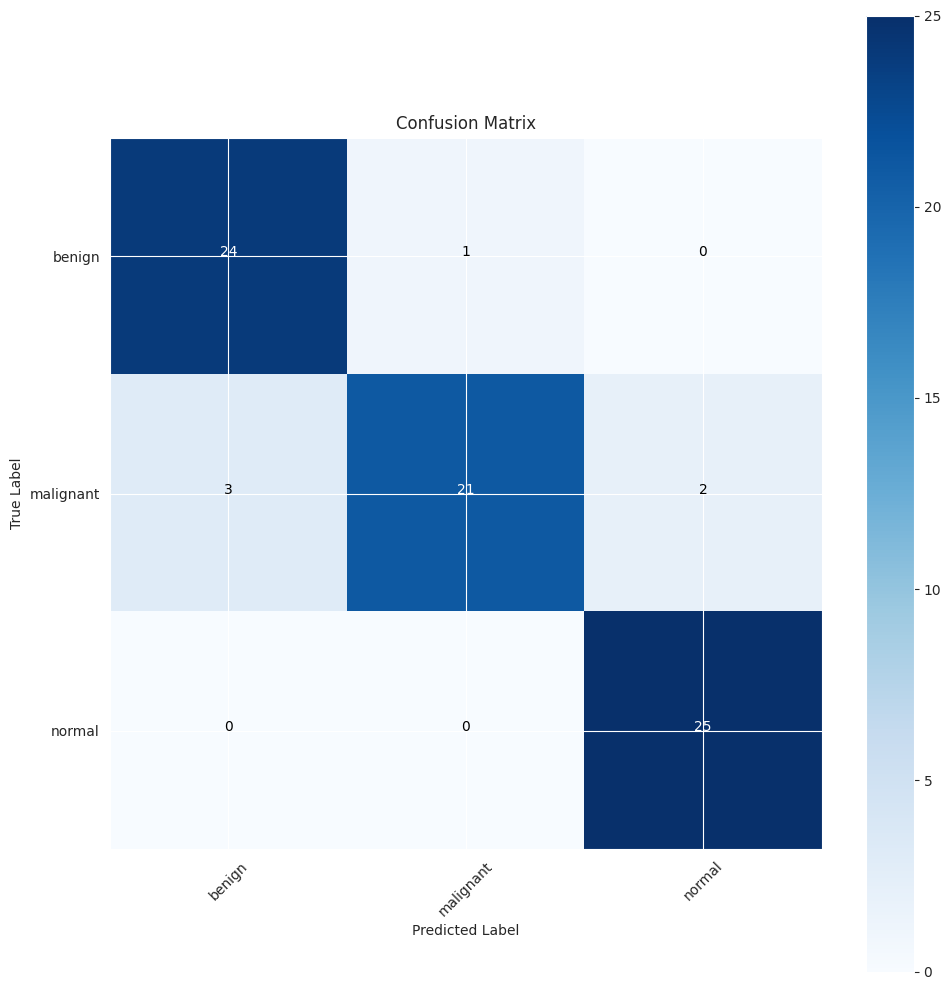

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

y_true = test_gen.classes

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

print('accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('recall: {:.4f}'.format(recall_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'
print('precision: {:.4f}'.format(precision_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'
print('f1: {:.4f}'.format(f1_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'

# ROC AUC score requires one-hot encoding for multi-class
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
print('roc_auc: {:.4f}'.format(roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr'))) # Changed to 'weighted' and added multi_class parameter


              precision    recall  f1-score   support

      benign       0.89      0.96      0.92        25
   malignant       0.95      0.81      0.88        26
      normal       0.93      1.00      0.96        25

    accuracy                           0.92        76
   macro avg       0.92      0.92      0.92        76
weighted avg       0.92      0.92      0.92        76

accuracy: 0.9211
recall: 0.9211
precision: 0.9235
f1: 0.9193
roc_auc: 0.9410


In [18]:
#Save the model
model.save('breat_usg_kaggle_efficient_b3_224x224.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


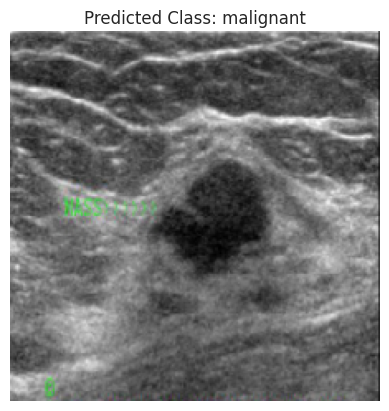

Prediction probabilities: [[0.2616967  0.5538407  0.18446258]]
Predicted class index: 1
Predicted class label: malignant


In [35]:
# prompt: wygeneruj kod do sprawdzajacy predykcje dla pliku /content/breast-usg/Dataset_BUSI_with_GT/benign/benign (9).png z prawdziwa kategoria tego obrazu

import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
#model = keras.models.load_model('/content/breat_usg_kaggle_efficient_b3_224x224.keras')

# Path to the image
img_path = '/content/rak_piersi.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Get class labels (assuming you have them defined somewhere)
# Replace this with your actual class labels if different
class_labels = ['benign', 'malignant', 'normal']

# Display the image and the prediction
plt.imshow(img)
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

print(f"Prediction probabilities: {prediction}")
print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {class_labels[predicted_class]}")



In [20]:
label_map = {'benign': '0', 'malignant': '1', 'normal': '2'}
#label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
print(label_map)
print(train_gen.class_indices)

{'benign': '0', 'malignant': '1', 'normal': '2'}
{'benign': 0, 'malignant': 1, 'normal': 2}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


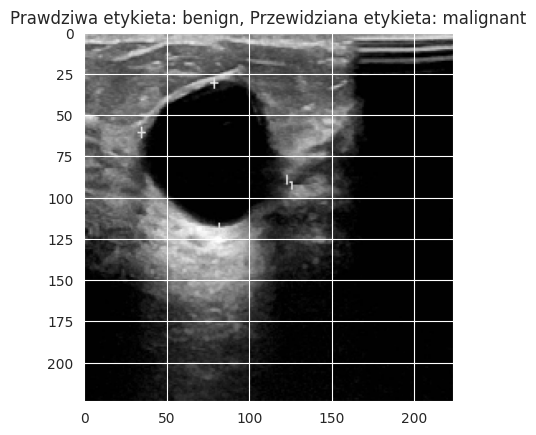

Prawdopodobieństwa klas: [0.24617216 0.56238914 0.19143872]
Klasy: ['benign', 'malignant', 'normal']


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/benign/benign (9).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size[0], img_size[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


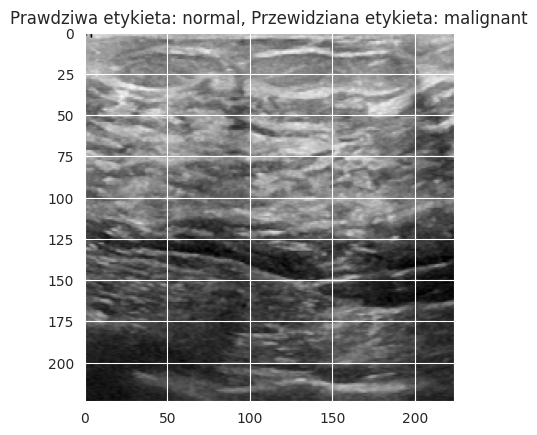

Prawdopodobieństwa klas: [0.25157252 0.5525536  0.19587392]
Klasy: ['benign', 'malignant', 'normal']


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/normal/normal (96).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size[0], img_size[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")


(224, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


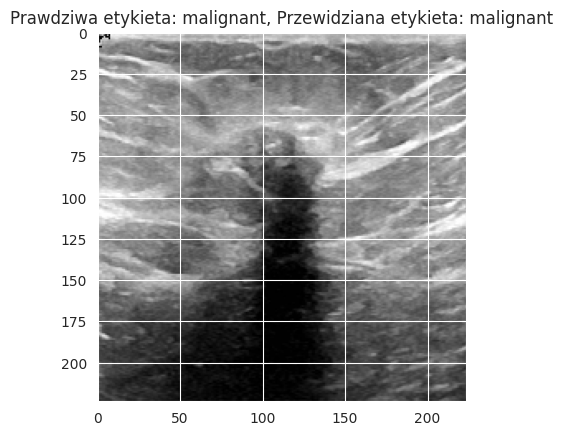

Prawdopodobieństwa klas: [0.25741678 0.544269   0.19831416]
Klasy: ['benign', 'malignant', 'normal']


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/malignant/malignant (90).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

print(img_size)

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size[0], img_size[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")
